In [1]:
import numpy as np
import math
from ase.build import nanotube
from ase.neighborlist import NeighborList
import nglview as nv
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython

In [2]:
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'STIXGeneral'

In [3]:
def selectUnitCellLength(indicator):
    if indicator == True:
        length = 2
    else:
        length = 1

    return length

In [4]:
def searchNearNeigh(p, q, swcnt, cutoff):
    rad = [cutoff / 2] * len(swcnt)
    neigh_res = {'neigh_check': None, 'r_p': None, 'r_q': None}

    nl = NeighborList(
        rad,
        self_interaction = False,
        bothways = True
    )

    nl.update(swcnt)

    neigh_idx, offsets = nl.get_neighbors(p)

    cell = swcnt.cell.array
    pos = swcnt.positions

    for l, off in zip(neigh_idx, offsets):
        if l == q:
            neigh_res['neigh_check'] = True
            neigh_res['r_p'] = pos[p]
            neigh_res['r_q'] = pos[q] + off @ cell

            return neigh_res

    neigh_res['neigh_check'] = False
    neigh_res['r_p'] = pos[p]
    neigh_res['r_q'] = pos[q]

    return neigh_res

In [5]:
def obtainLockVars(d, E_2s, E_2p, p, q, swcnt, k):
    E_2s_loc, E_2p_loc, r, calc_exp = 0, 0, 1, 0
    
    neigh_res = searchNearNeigh(p, q, swcnt, 1.01 * d)

    if neigh_res['neigh_check'] == True:
        r = math.sqrt((neigh_res['r_q'][0] - neigh_res['r_p'][0]) ** 2 + (neigh_res['r_q'][1] - neigh_res['r_p'][1]) ** 2 + (neigh_res['r_q'][2] - neigh_res['r_p'][2]) ** 2)
        calc_exp = np.exp(-1j * k * (neigh_res['r_q'][2] - neigh_res['r_p'][2]))

    if p == q:
        E_2s_loc = E_2s
        E_2p_loc = E_2p
        
    return E_2s_loc, E_2p_loc, neigh_res['r_p'], neigh_res['r_q'], r, calc_exp

In [6]:
def createHamiltBlock(d, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, p, q, swcnt, k):
    E_2s_loc, E_2p_loc, coords_p, coords_q, r, calc_exp = obtainLockVars(d, E_2s, E_2p, p, q, swcnt, k)
    hamilt_block = np.zeros([4, 4], dtype = complex)

    for i in range(1, 5):
        for j in range(1, 5):
            if i == j:
                if i == 1:
                    hamilt_block[i - 1][j - 1] = E_2s_loc - t_ss_sgm * calc_exp
                else:
                    hamilt_block[i - 1][j - 1] = E_2p_loc - ((((coords_q[i - 2] - coords_p[i - 2]) / r) ** 2) * t_pp_sgm + (1 - ((coords_q[i - 2] - coords_p[i - 2]) / r) ** 2) * t_pp_p) * calc_exp
            else:
                if i == 1:
                    hamilt_block[i - 1][j - 1] = (coords_q[j - 2] - coords_p[j - 2]) * t_sp_sgm * calc_exp / r
                elif j == 1:
                    hamilt_block[i - 1][j - 1] = -(coords_q[i - 2] - coords_p[i - 2]) * t_sp_sgm * calc_exp / r
                else:
                    hamilt_block[i - 1][j - 1] = -(coords_q[i - 2] - coords_p[i - 2]) * (coords_q[j - 2] - coords_p[j - 2]) * (t_pp_sgm - t_pp_p) * calc_exp / (r ** 2)

    return hamilt_block

In [7]:
def createHamilt(d, N, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, swcnt, k):
    hamilt = np.zeros([4 * N, 4 * N], dtype = complex)

    for i in range(0, 4 * N, 4):
        for j in range(0, 4 * N, 4):
            hamilt[i: i + 4, j: j + 4] = createHamiltBlock(d, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, i // 4, j // 4, swcnt, k)

    return hamilt

In [8]:
def calcEigVals(d, N, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, swcnt, k):
    hamilt = createHamilt(d, N, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, swcnt, k)
    eig_vals_res = np.linalg.eigvals(hamilt).real
    eig_vals_res.sort()
    
    return eig_vals_res

In [9]:
def calcBandGap(eig_vals_res):
    max_val = (np.max(eig_vals_res[:, 0]))
    min_cond = (np.min(eig_vals_res[:, 1]))
    band_gap = round(max((min_cond.real - max_val.real), 0.00), 2)

    return band_gap

In [10]:
def plotBandStr(n, m, T, k, eig_vals_res):
    x_lim = math.pi / T
    x_tick = np.array([-x_lim, 0, x_lim])
    x_label = [r"- $\frac{\pi}{T}$", r"$0$", r"$\frac{\pi}{T}$"]

    fig = plt.figure(figsize = (5, 4))

    ax = fig.add_subplot(111)
    ax.plot(k, eig_vals_res, color = 'black', linewidth = 0.5)
    ax.set_xticks(x_tick)
    ax.set_xticklabels(x_label, fontsize = 12)
    ax.set_xlabel(r"$k$", fontsize = 12)
    ax.set_ylabel(r"$E,\ \mathrm{eV}$", fontsize = 12)
    ax.set_xlim([-x_lim, x_lim])

    plt.savefig(f"[{n}; {m}]SWCNT_band_str.eps")
    plt.show()

In [11]:
n = 2
m = 4
d = 1.42

In [12]:
t_ss_sgm = -4.30
t_sp_sgm = 4.98
t_pp_sgm = 6.38
t_pp_p = -2.66
E_2s = -7.30
E_2p = 0.00

In [13]:
unit_cell_length = selectUnitCellLength(n == m)
N = unit_cell_length * int(4 * (n ** 2 + m ** 2 + n * m) / math.gcd(2 * n + m, 2 * m + n))
T = 3 * d * math.sqrt(n ** 2 + m ** 2 + n * m) / math.gcd(2 * n + m, 2 * m + n)

In [14]:
k = np.linspace((-math.pi) / T, (math.pi) / T, 300)

In [15]:
swcnt = nanotube(n, m, length = unit_cell_length, bond = d)
w = nv.show_ase(swcnt)
w.add_ball_and_stick()
w.add_label(color = "black", labelType = "atomindex")
IPython.display.display(w)

NGLWidget()

Band Gap = 1.91 eV


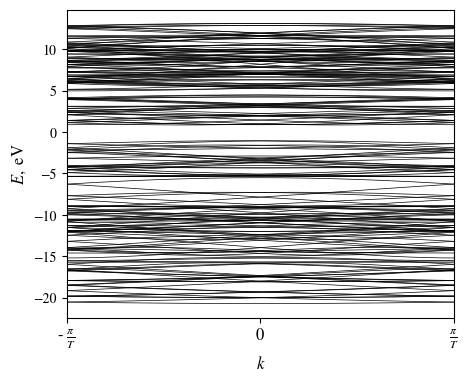

In [16]:
eig_vals_res = np.array([calcEigVals(d, N, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, swcnt, i) for i in k])
print(f"Band Gap = {calcBandGap(eig_vals_res[:, 2 * N - 1: 2 * N + 1])} eV")
plotBandStr(n, m, T, k, eig_vals_res)